# Behavioral Analysis
## - evidence of conflicting value maps in States A and B but not C

In [1]:
import h5_utilities_module as h5u
import numpy as np
import pandas as pd
import pingouin as pg
from tqdm import tqdm
from matplotlib import pyplot as plt

In [2]:
# define the directory where the files live
data_dir = '/Users/thomaselston/Documents/PYTHON/self_control/raw_data/'
data_files = h5u.find_h5_files(data_dir)


In [3]:
# functions!
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.mean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
        
    elif type == 'bootstrap':
        n_rows, n_cols = data.shape
        alpha = alpha/2

        # Initialize array to store bootstrap means
        
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
            bootstrap_means[:, col] = np.mean(bootstrap_samples, axis=1)

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.mean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.mean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    return nanmean_result, interval

In [4]:
# loop over the files and accumulate the behavioral data

# initialize a dataframe
bhv = pd.DataFrame()

for this_file in tqdm(data_files):
    
    # pull this file's behavior
    f_data = pd.read_hdf(this_file, key='bhv')

    # Append the data to the accumulated dataframe
    bhv = pd.concat([bhv, f_data], ignore_index=True)

100%|██████████| 8/8 [00:00<00:00, 22.16it/s]


In [5]:
# create indices to separately analyze each monkey
k_ix = bhv['fname'].str.contains('K')
d_ix = bhv['fname'].str.contains('D')

In [6]:
# get overall choice accuracies
k_acc = bhv['picked_best'].loc[k_ix].mean()
d_acc = bhv['picked_best'].loc[d_ix].mean()

print('subject K accuracy: ' + str(k_acc*100))
print('subject D accuracy: ' + str(d_acc*100))

subject K accuracy: 98.81312543635094
subject D accuracy: 97.78645833333334


In [7]:
# find the identities of the value differences
val_diff = bhv['l_val'] - bhv['r_val']
val_diff_ids = np.unique(val_diff[~np.isnan(val_diff)])
# find the trials where the monkey picked the left option

picked_left = (bhv['side'] == -1).to_numpy().astype(int).reshape((-1, 1))
rt = bhv['rt'].values.reshape((-1,1))
n_sacc = bhv['n_sacc'].values.reshape(-1,1)

# we're only going to assess the free choices
free_ix = bhv['forced'] == 0

# initialize arrays to accumulate results into
# choice accuracy
choice_acc_mean = np.zeros((3, len(val_diff_ids), 2)) # 3 states, n_val_diffs, 2 monkeys
choice_acc_ci = np.zeros((3, len(val_diff_ids), 2)) # 3 states, n_val_diffs, 2 monkeys

# choice reaction time
choice_rt_mean = np.zeros((3, len(val_diff_ids), 2)) # 3 states, n_val_diffs, 2 monkeys
choice_rt_ci = np.zeros((3, len(val_diff_ids), 2)) # 3 states, n_val_diffs, 2 monkeys


# loop over the val_diff_ids and get the mean for each value difference and state
for v_num, v_id in enumerate(val_diff_ids):

    # find the trials associated with this value difference
    v_ix = val_diff == v_id

    # take the means and 95% CIs
    choice_acc_mean[0, v_num, 0], choice_acc_ci[0, v_num, 0] = calculate_mean_and_interval(picked_left[free_ix & v_ix & (bhv['state'] == 1) & k_ix], 'bootstrap')
    choice_acc_mean[1, v_num, 0], choice_acc_ci[1, v_num, 0] = calculate_mean_and_interval(picked_left[free_ix & v_ix & (bhv['state'] == 2) & k_ix], 'bootstrap')
    choice_acc_mean[2, v_num, 0], choice_acc_ci[2, v_num, 0] = calculate_mean_and_interval(picked_left[free_ix & v_ix & (bhv['state'] == 3) & k_ix], 'bootstrap')

    choice_acc_mean[0, v_num, 1], choice_acc_ci[0, v_num, 1] = calculate_mean_and_interval(picked_left[free_ix & v_ix & (bhv['state'] == 1) & d_ix], 'bootstrap')
    choice_acc_mean[1, v_num, 1], choice_acc_ci[1, v_num, 1] = calculate_mean_and_interval(picked_left[free_ix & v_ix & (bhv['state'] == 2) & d_ix], 'bootstrap')
    choice_acc_mean[2, v_num, 1], choice_acc_ci[2, v_num, 1] = calculate_mean_and_interval(picked_left[free_ix & v_ix & (bhv['state'] == 3) & d_ix], 'bootstrap')

    choice_rt_mean[0, v_num, 0], choice_rt_ci[0, v_num, 0] = calculate_mean_and_interval(rt[free_ix & v_ix & (bhv['state'] == 1) & k_ix], 'bootstrap')
    choice_rt_mean[1, v_num, 0], choice_rt_ci[1, v_num, 0] = calculate_mean_and_interval(rt[free_ix & v_ix & (bhv['state'] == 2) & k_ix], 'bootstrap')
    choice_rt_mean[2, v_num, 0], choice_rt_ci[2, v_num, 0] = calculate_mean_and_interval(rt[free_ix & v_ix & (bhv['state'] == 3) & k_ix], 'bootstrap')

    choice_rt_mean[0, v_num, 1], choice_rt_ci[0, v_num, 1] = calculate_mean_and_interval(rt[free_ix & v_ix & (bhv['state'] == 1) & d_ix], 'bootstrap')
    choice_rt_mean[1, v_num, 1], choice_rt_ci[1, v_num, 1] = calculate_mean_and_interval(rt[free_ix & v_ix & (bhv['state'] == 2) & d_ix], 'bootstrap')
    choice_rt_mean[2, v_num, 1], choice_rt_ci[2, v_num, 1] = calculate_mean_and_interval(rt[free_ix & v_ix & (bhv['state'] == 3) & d_ix], 'bootstrap')

/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/4175741094.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  choice_acc_mean[0, v_num, 0], choice_acc_ci[0, v_num, 0] = calculate_mean_and_interval(picked_left[free_ix & v_ix & (bhv['state'] == 1) & k_ix], 'bootstrap')
/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/4175741094.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  choice_acc_mean[1, v_num, 0], choice_acc_ci[1, v_num, 0] = calculate_mean_and_interval(picked_left[free_ix & v_ix & (bhv['state'] == 2) & k_ix], 'bootstrap')
/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/4175741

In [8]:
# find the value of the item the animals first saccaded towards on double-take trials
double_take_ix = (bhv['n_sacc'] == 2) & free_ix

# initialize an array to accumulate results into
first_sacc_mean = np.zeros((2, 2)) # 3 states x 2 monkeys
first_sacc_ci = np.zeros((2, 2)) # 3 states x 2 monkeys


# get the values fixated on double takes
sacc1_vals = bhv['sacc1_val'].values.reshape(-1,1)

# calculate means and confidence intervals
first_sacc_mean[0,0], first_sacc_ci[0,0] = calculate_mean_and_interval(sacc1_vals[double_take_ix & k_ix & (bhv['state']<3)], 'bootstrap')
first_sacc_mean[1,0], first_sacc_ci[1,0] = calculate_mean_and_interval(sacc1_vals[double_take_ix & k_ix & (bhv['state']==3)], 'bootstrap')

first_sacc_mean[0,1], first_sacc_ci[0,1] = calculate_mean_and_interval(sacc1_vals[double_take_ix & d_ix & (bhv['state']<3)], 'bootstrap')
first_sacc_mean[1,1], first_sacc_ci[1,1] = calculate_mean_and_interval(sacc1_vals[double_take_ix & d_ix & (bhv['state']==3)], 'bootstrap')


/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/3500902538.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  first_sacc_mean[0,0], first_sacc_ci[0,0] = calculate_mean_and_interval(sacc1_vals[double_take_ix & k_ix & (bhv['state']<3)], 'bootstrap')
/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/3500902538.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  first_sacc_mean[1,0], first_sacc_ci[1,0] = calculate_mean_and_interval(sacc1_vals[double_take_ix & k_ix & (bhv['state']==3)], 'bootstrap')
/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/3500902538.py:16: DeprecationWarning: Conversi

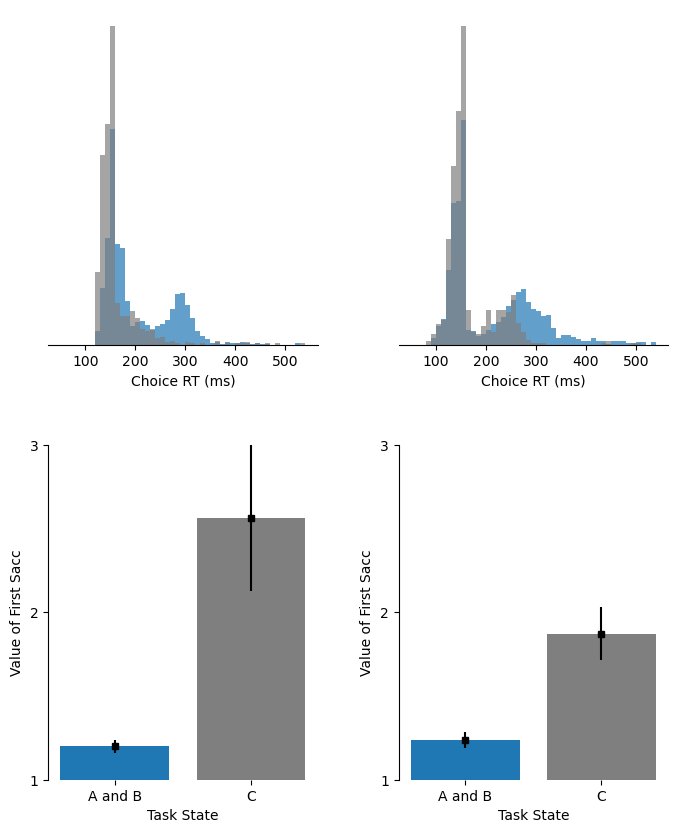

In [9]:
# now let's plot

fig, ax = plt.subplots(2, 2, figsize=(8,10))
# Adjust space between subplots
fig.subplots_adjust(wspace=0.3, hspace=.3)  # add some white space between the plots

# define bins for the histogram
bins = np.arange(50, 550, 10)
x_vals = [0,1]

# plot King's data

# choice RT histograms
ax[0,0].hist(bhv['rt'].loc[k_ix & (bhv['state'] <3) & free_ix], bins=bins, density='probability', alpha = .7, color='tab:blue')
ax[0,0].hist(bhv['rt'].loc[k_ix & (bhv['state'] == 3) & free_ix], bins=bins, density='probability', alpha = .7, color='tab:gray')
ax[0,0].set_xlabel('Choice RT (ms)')
ax[0,0].spines['right'].set_visible(False)
ax[0,0].spines['left'].set_visible(False)
ax[0,0].spines['top'].set_visible(False)
ax[0,0].set_yticks(())
ax[0,0].set_xticks((100, 200, 300, 400, 500))


# value of first saccade by state
ax[1,0].bar(0, first_sacc_mean[0,0], color='tab:blue')
ax[1,0].bar(1, first_sacc_mean[1,0], color='tab:gray')
ax[1,0].errorbar(x_vals, first_sacc_mean[:, 0], first_sacc_ci[:, 0], linestyle='none', color='black', marker='s', ms = 5)
ax[1,0].set_xticks(x_vals)
ax[1,0].set_xticklabels(('A and B', 'C'))
ax[1,0].spines['right'].set_visible(False)
ax[1,0].spines['top'].set_visible(False)
ax[1,0].spines['bottom'].set_visible(False)
ax[1,0].set_xlabel('Task State')
ax[1,0].set_ylabel('Value of First Sacc')
ax[1,0].set_ylim((1, 3))
ax[1,0].set_yticks((1, 2, 3))




# Don

# choice RT histograms
ax[0,1].hist(bhv['rt'].loc[d_ix & (bhv['state'] <3) & free_ix], bins=bins, density='probability', alpha = .7, color='tab:blue')
ax[0,1].hist(bhv['rt'].loc[d_ix & (bhv['state'] == 3) & free_ix], bins=bins, density='probability', alpha = .7, color='tab:gray')
ax[0,1].set_xlabel('Choice RT (ms)')
ax[0,1].spines['right'].set_visible(False)
ax[0,1].spines['left'].set_visible(False)
ax[0,1].spines['top'].set_visible(False)
ax[0,1].set_yticks(())
ax[0,1].set_xticks((100, 200, 300, 400, 500))

# value of first saccade by state
ax[1,1].bar(0, first_sacc_mean[0,1], color='tab:blue')
ax[1,1].bar(1, first_sacc_mean[1,1], color='tab:gray')
ax[1,1].errorbar(x_vals, first_sacc_mean[:, 1], first_sacc_ci[:, 1], linestyle='none', color='black', marker='s', ms = 5)
ax[1,1].set_xticks(x_vals)
ax[1,1].set_xticklabels(('A and B', 'C'))
ax[1,1].spines['right'].set_visible(False)
ax[1,1].spines['top'].set_visible(False)
ax[1,1].spines['bottom'].set_visible(False)
ax[1,1].set_xlabel('Task State')
ax[1,1].set_ylabel('Value of First Sacc')
ax[1,1].set_ylim((1, 3))
ax[1,1].set_yticks((1, 2, 3))

# save the figure as a png
#plt.savefig("RTs_and_vals.svg")


In [10]:
# Get the RTs for each state
# initialize an array to accumulate results into
rt_by_state_mean = np.zeros((3, 2)) # 3 states x 2 monkeys
rt_by_state_ci = np.zeros((3, 2)) # 3 states x 2 monkeys

# calculate means and confidence intervals
rt_by_state_mean[0,0], rt_by_state_ci[0,0] = calculate_mean_and_interval(rt[free_ix & k_ix & (bhv['state']==1)], 'bootstrap')
rt_by_state_mean[1,0], rt_by_state_ci[1,0] = calculate_mean_and_interval(rt[free_ix & k_ix & (bhv['state']==2)], 'bootstrap')
rt_by_state_mean[2,0], rt_by_state_ci[2,0] = calculate_mean_and_interval(rt[free_ix & k_ix & (bhv['state']==3)], 'bootstrap')

rt_by_state_mean[0,1], rt_by_state_ci[0,1] = calculate_mean_and_interval(rt[free_ix & d_ix & (bhv['state']==1)], 'bootstrap')
rt_by_state_mean[1,1], rt_by_state_ci[1,1] = calculate_mean_and_interval(rt[free_ix & d_ix & (bhv['state']==2)], 'bootstrap')
rt_by_state_mean[2,1], rt_by_state_ci[2,1] = calculate_mean_and_interval(rt[free_ix & d_ix & (bhv['state']==3)], 'bootstrap')

/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/1242905544.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rt_by_state_mean[0,0], rt_by_state_ci[0,0] = calculate_mean_and_interval(rt[free_ix & k_ix & (bhv['state']==1)], 'bootstrap')
/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/1242905544.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rt_by_state_mean[1,0], rt_by_state_ci[1,0] = calculate_mean_and_interval(rt[free_ix & k_ix & (bhv['state']==2)], 'bootstrap')
/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/1242905544.py:9: DeprecationWarning: Conversion of an array with ndim > 0

ValueError: 'x' and 'y' must have the same size

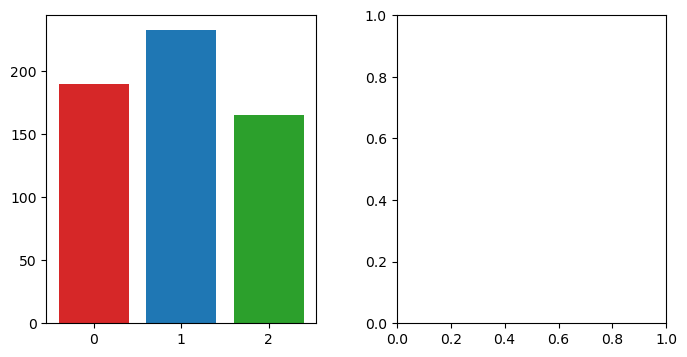

In [11]:
# plot the mean RT by state

fig, ax = plt.subplots(1, 2, figsize=(8,4))
# Adjust space between subplots
fig.subplots_adjust(wspace=0.3, hspace=.3)  # add some white space between the plots


# value of first saccade by state
ax[0].bar(0, rt_by_state_mean[0,0], color='tab:red')
ax[0].bar(1, rt_by_state_mean[1,0], color='tab:blue')
ax[0].bar(2, rt_by_state_mean[2,0], color='tab:green')
ax[0].errorbar(x_vals, rt_by_state_mean[:, 0], rt_by_state_ci[:, 0], linestyle='none', color='black', marker='s', ms = 5)
ax[0].set_xticks(x_vals)
ax[0].set_ylim((100, 250))
ax[0].set_yticks((100, 150, 200, 250))
ax[0].set_xticklabels(('A', 'B', 'C'))
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].spines['bottom'].set_visible(False)
ax[0].set_xlabel('Task State')
ax[0].set_ylabel('RT (ms)')
ax[0].set_title('Subject K')

ax[1].bar(0, rt_by_state_mean[0,1], color='tab:red')
ax[1].bar(1, rt_by_state_mean[1,1], color='tab:blue')
ax[1].bar(2, rt_by_state_mean[2,1], color='tab:green')
ax[1].errorbar(x_vals, rt_by_state_mean[:, 1], rt_by_state_ci[:, 1], linestyle='none', color='black', marker='s', ms = 5)
ax[1].set_xticks(x_vals)
ax[1].set_ylim((100, 250))
ax[1].set_yticks((100, 150, 200, 250))
ax[1].set_xticklabels(('A', 'B', 'C'))
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].spines['bottom'].set_visible(False)
ax[1].set_xlabel('Task State')
ax[1].set_title('Subject D')



In [11]:
# do some t-tests of RTs across the states

# King
k_AvsB_ttest = pg.ttest(bhv['rt'].loc[k_ix & (bhv['state'] == 1) & free_ix], 
                        bhv['rt'].loc[k_ix & (bhv['state'] == 2) & free_ix])

k_AvsC_ttest = pg.ttest(bhv['rt'].loc[k_ix & (bhv['state'] == 1) & free_ix], 
                        bhv['rt'].loc[k_ix & (bhv['state'] == 3) & free_ix])

k_BvsC_ttest = pg.ttest(bhv['rt'].loc[k_ix & (bhv['state'] == 2) & free_ix], 
                        bhv['rt'].loc[k_ix & (bhv['state'] == 3) & free_ix])

# Don
d_AvsB_ttest = pg.ttest(bhv['rt'].loc[d_ix & (bhv['state'] == 1) & free_ix], 
                        bhv['rt'].loc[d_ix & (bhv['state'] == 2) & free_ix])

d_AvsC_ttest = pg.ttest(bhv['rt'].loc[d_ix & (bhv['state'] == 1) & free_ix], 
                        bhv['rt'].loc[d_ix & (bhv['state'] == 3) & free_ix])

d_BvsC_ttest = pg.ttest(bhv['rt'].loc[d_ix & (bhv['state'] == 2) & free_ix], 
                        bhv['rt'].loc[d_ix & (bhv['state'] == 3) & free_ix])

In [14]:
# find the number of saccades as a function of each left/right choice

val_ids = np.unique(bhv['l_val'].loc[~np.isnan(bhv['l_val'])])
n_vals = len(val_ids)

state_AB_ix = bhv['state'] < 3
state_C_ix = bhv['state'] == 3



rt_by_val_and_state = np.zeros((n_vals, n_vals, 2, 2)) # each left-right value combination, 2 states, 2 monkeys
rt_by_val_and_state[:] = np.nan

n_sacc_by_val_and_state = np.zeros((n_vals, n_vals, 2, 2)) # each left-right value combination, 2 states, 2 monkeys
n_sacc_by_val_and_state[:] = np.nan

# loop over each combination of left and right values
for l_ix, l_val in enumerate(val_ids):
    for r_ix, r_val in enumerate(val_ids):

        val_combi_ix = (bhv['l_val'] == l_val) & (bhv['r_val'] == r_val)

        if r_val != l_val:
            rt_by_val_and_state[l_ix, r_ix, 0, 0] = np.nanmean(rt[val_combi_ix & free_ix & k_ix & state_AB_ix], axis=0)
            rt_by_val_and_state[l_ix, r_ix, 1, 0] = np.nanmean(rt[val_combi_ix & free_ix & k_ix & state_C_ix], axis=0)

            rt_by_val_and_state[l_ix, r_ix, 0, 1] = np.nanmean(rt[val_combi_ix & free_ix & d_ix & state_AB_ix], axis=0)
            rt_by_val_and_state[l_ix, r_ix, 1, 1] = np.nanmean(rt[val_combi_ix & free_ix & d_ix & state_C_ix], axis=0)

            n_sacc_by_val_and_state[l_ix, r_ix, 0, 0] = np.nanmean(n_sacc[val_combi_ix & free_ix & k_ix & state_AB_ix], axis=0)
            n_sacc_by_val_and_state[l_ix, r_ix, 1, 0] = np.nanmean(n_sacc[val_combi_ix & free_ix & k_ix & state_C_ix], axis=0)

            n_sacc_by_val_and_state[l_ix, r_ix, 0, 1] = np.nanmean(n_sacc[val_combi_ix & free_ix & d_ix & state_AB_ix], axis=0)
            n_sacc_by_val_and_state[l_ix, r_ix, 1, 1] = np.nanmean(n_sacc[val_combi_ix & free_ix & d_ix & state_C_ix], axis=0)


/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/3808621062.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rt_by_val_and_state[l_ix, r_ix, 0, 0] = np.nanmean(rt[val_combi_ix & free_ix & k_ix & state_AB_ix], axis=0)
/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/3808621062.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rt_by_val_and_state[l_ix, r_ix, 1, 0] = np.nanmean(rt[val_combi_ix & free_ix & k_ix & state_C_ix], axis=0)
/var/folders/cg/r9y7pd9n64q8dlrv539z9yyh0000gn/T/ipykernel_25163/3808621062.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and wi

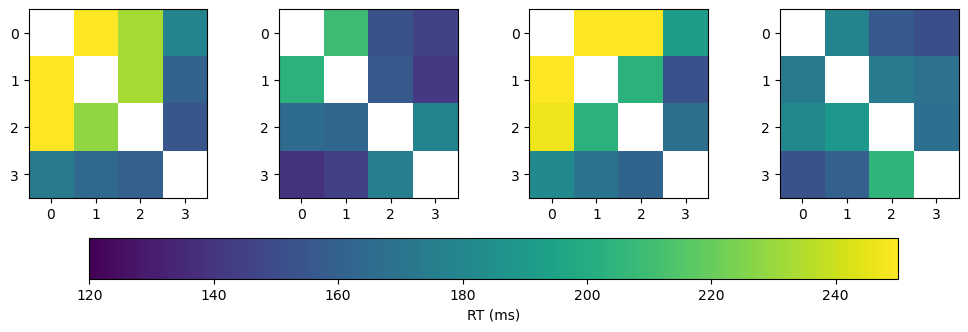

<Figure size 640x480 with 0 Axes>

In [29]:
# show mean RTs and mean n_sacc for all trial conditions separately
fig, ax = plt.subplots(1, 4, figsize=(12, 3.5))
fig.subplots_adjust(wspace=0.4, hspace=.4)  # add some white space between the plots
rt_min = 120
rt_max = 250

# organized as:
# subject as column pairs (leftmost is subj K's RTs, then K's n_sacc, then D's RTs, then D's n_sacc)
im0 = ax[0].imshow(rt_by_val_and_state[:,:,0, 0], aspect='auto', vmin=rt_min, vmax=rt_max)
im1 = ax[1].imshow(rt_by_val_and_state[:,:,1, 0], aspect='auto', vmin=rt_min, vmax=rt_max)
im2 = ax[2].imshow(rt_by_val_and_state[:,:,0, 1], aspect='auto', vmin=rt_min, vmax=rt_max)
im3 = ax[3].imshow(rt_by_val_and_state[:,:,1, 1], aspect='auto', vmin=rt_min, vmax=rt_max)

# Add a single colorbar shared for all RT plots
fig.colorbar(im0, ax=ax, orientation='horizontal', label='RT (ms)')

plt.show()
#plt.savefig("RTs_by_cond.svg")


